In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import air_traff_utils as atu
from sklearn import preprocessing

import ipdb

In [2]:
atu.setup_seed(12)

In [3]:
def plot_tensor_quick(tensor):
#     plt.figure()
    try:
        plt.plot(tensor.cpu().detach().numpy())
    except Exception as e:
        plt.plot(tensor.detach().numpy())

# Loading Data

In [4]:
us_CSA = pd.read_csv('./data/us_CSA.csv', index_col=0)
OD_df = pd.read_csv('./outputs/201904_OD_CSA.csv', index_col=0).sort_index(axis=0).sort_index(axis=1)
CSA_df = pd.read_csv('./data/CSA_df.csv')

In [5]:
combined_airports3 = ['NYC', 'WAS']
OD_df.loc[combined_airports3] = OD_df.loc[combined_airports3]/3
OD_df[combined_airports3] = OD_df[combined_airports3]/3
OD_df.loc[combined_airports3, combined_airports3] = OD_df.loc[combined_airports3, combined_airports3]*3

combined_airports2 = ['CHI', 'MIA']
OD_df.loc[combined_airports2] = OD_df.loc[combined_airports2]/2
OD_df[combined_airports2] = OD_df[combined_airports2]/2
OD_df.loc[combined_airports2, combined_airports2] = OD_df.loc[combined_airports2, combined_airports2]*2


In [6]:
# normalize OD
scalar_OD = preprocessing.MinMaxScaler().fit(OD_df.to_numpy().reshape(-1, 1))
OD_df_values = scalar_OD.transform(OD_df.to_numpy().reshape(-1, 1)).reshape(24, 24)
OD_df = pd.DataFrame(OD_df_values, index=OD_df.index, columns=OD_df.columns)

In [7]:
us_CSA_use = us_CSA.loc[us_CSA['if_plot']==1]
print(us_CSA_use.shape)
us_CSA_use.head(2)

(24, 26)


,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
6,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.165852 32.808496999999996, -85.1..."
13,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,1051349,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.883921 41.326498, -71.8821..."


In [8]:
data_X_df = pd.DataFrame(us_CSA_use.copy().drop(['CSA', 'CBSA', 'CBSA_Name', 'geometry', 'if_plot'], axis=1))
data_X_df.index = range(data_X_df.shape[0])
data_X_df.head(2)

,TotPop,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,E_HiWageWk,D1B,D1C,...,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name
0,6584708,142257,759558,1449909,2970375,668868,969644,1331863,4.184264,2.193174,...,-67955.508346,0.026778,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ..."
1,8200935,349774,1079810,1704849,3823517,825804,1051349,1946364,13.357811,5.484528,...,-39255.813819,0.150468,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT"


In [9]:
data_X_df['CSA_Code'] = ''
for i in data_X_df.index:
    CSA_Name = data_X_df.loc[i, 'CSA_Name']
    data_X_df.loc[i, 'CSA_Code'] = CSA_df.loc[CSA_df['CSA_Name']==CSA_Name, 'Airport'].values[0]

data_X_df = data_X_df[['TotPop', 'D3A', 'D4A', 'INTPTLAT', 'INTPTLON', 'CSA_Name', 'CSA_Code']]
print(data_X_df.shape)
data_X_df.head(2)

(24, 7)


,TotPop,D3A,D4A,INTPTLAT,INTPTLON,CSA_Name,CSA_Code
0,6584708,11.808044,-67955.508346,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",ATL
1,8200935,18.586822,-39255.813819,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",BOS


In [10]:
data_X_df.index = data_X_df['CSA_Code']
data_X_df.loc[combined_airports3, ['TotPop', 'D3A', 'D4A']] = data_X_df.loc[combined_airports3, ['TotPop', 'D3A', 'D4A']]/3
data_X_df.loc[combined_airports2, ['TotPop', 'D3A', 'D4A']] = data_X_df.loc[combined_airports2, ['TotPop', 'D3A', 'D4A']]/2
data_X_df.index = range(data_X_df.shape[0])


In [11]:
# standardize data_X
data_X_df_f = data_X_df.loc[:, ['TotPop', 'D3A', 'D4A']]
scalar_data_X_feature = preprocessing.StandardScaler().fit(np.array(data_X_df_f))
data_X_df.loc[:, ['TotPop', 'D3A', 'D4A']] = scalar_data_X_feature.transform(np.array(data_X_df_f))


In [12]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

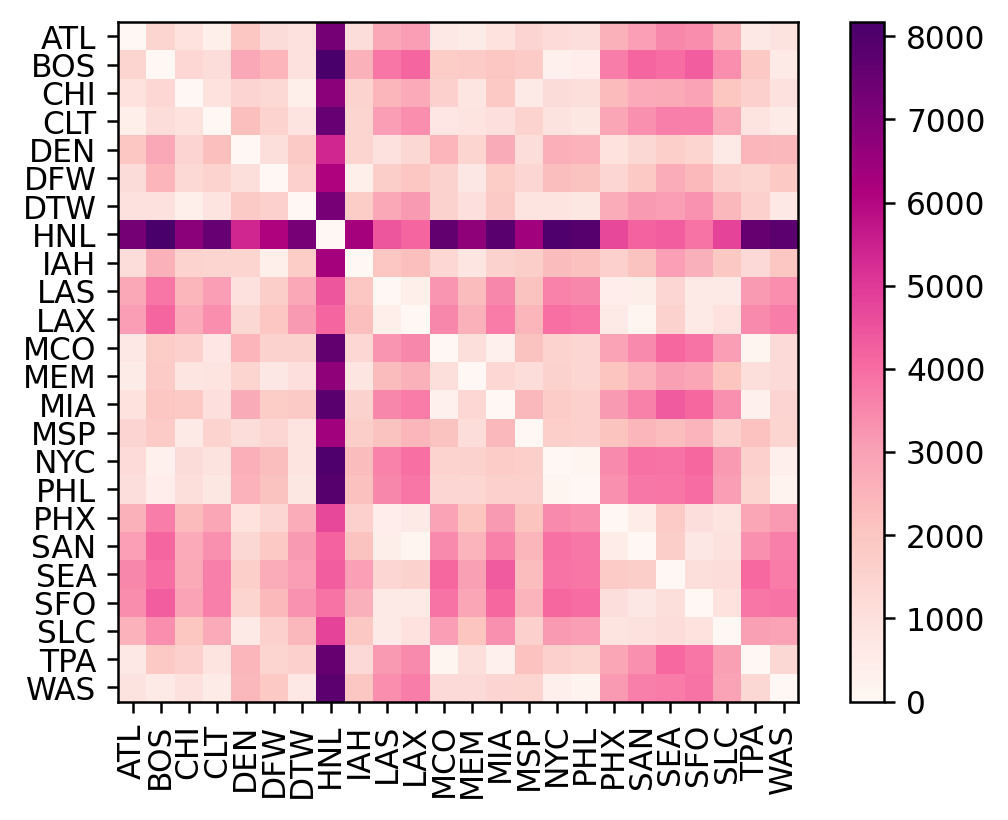

In [13]:
dist_mat = np.zeros([24, 24])
for i in range(24):
    lat1 = data_X_df.loc[i, 'INTPTLAT']
    lon1 = data_X_df.loc[i, 'INTPTLON']
    for j in range(24):
        lat2 = data_X_df.loc[j, 'INTPTLAT']
        lon2 = data_X_df.loc[j, 'INTPTLON']
        
        dist_mat[i, j] = distance(lat1, lat2, lon1, lon2)

dist_df = pd.DataFrame(dist_mat, index=data_X_df['CSA_Code'], columns=data_X_df['CSA_Code'])
dist_df = dist_df.sort_index(axis=0).sort_index(axis=1)

plt.figure(dpi=225)
plt.imshow(dist_df, cmap='RdPu')
plt.yticks(range(24), dist_df.index)
plt.xticks(range(24), dist_df.columns, rotation=90)
plt.colorbar()

dist_vec = dist_mat.reshape(-1, 1)
scalar_dist = preprocessing.MinMaxScaler().fit(dist_vec)
dist_vec = scalar_dist.transform(dist_vec)
dist_mat = dist_vec.reshape(24, 24)


(24, 24)


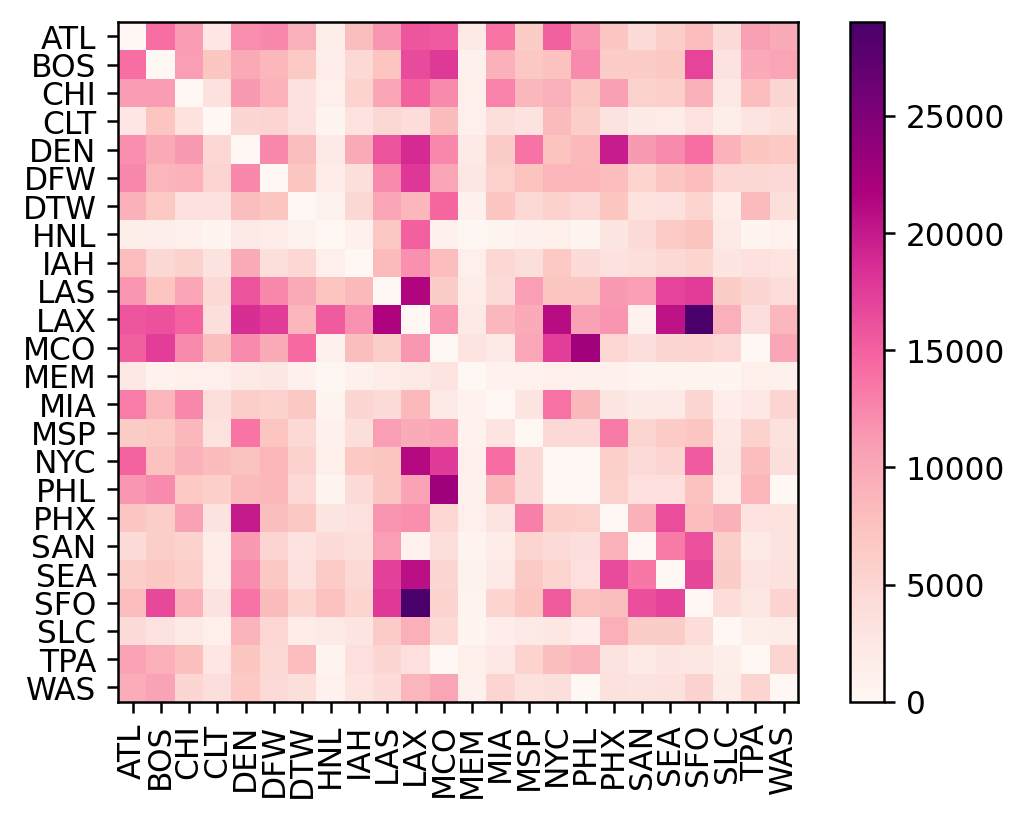

In [52]:
# Illustration of OD matrix
print(OD_df.shape)
plt.figure(dpi=225)

plt.imshow(OD_df*29011, cmap='RdPu')
plt.yticks(range(24), OD_df.index)
plt.xticks(range(24), OD_df.index, rotation=90)
plt.colorbar()


# Prepare Feature Pairs
## For each OD pair in the OD matrix, it has its feature combination, [feature of loc1, feature of loc2, distance]

In [15]:
from itertools import combinations

In [16]:
sample_size = 100
loc_comb = np.array(list(combinations(range(14), 10)))  # 从14个地点中选10个
loc_sampled = loc_comb[np.random.randint(loc_comb.shape[0], size=sample_size), :]
print(loc_sampled.shape)

(100, 10)


In [17]:
OD = np.array(OD_df)  # shape: [num_cities, num_cities]

OD_train_2d = OD[:14, 14]
OD_train_val = np.zeros([sample_size**2, 10**2])
for i in range(sample_size):
    org = OD_df.index[loc_sampled[i, :]]
    for j in range(sample_size):
        dest = OD_df.index[loc_sampled[j, :]]
        OD_ij = OD_df.loc[org][dest]
        OD_ij = np.array(OD_ij).flatten()
        OD_train_val[i*sample_size+j, :] = OD_ij

OD_val_2d = OD[14:, 14:]
OD_val = OD_val_2d.reshape(1, -1)
OD_train_val = np.append(OD_train_val, OD_val, axis=0)

print(OD_train_val.shape)

(10001, 100)


In [18]:
data_X_df.index = data_X_df['CSA_Code'].values

data_X = np.zeros([sample_size**2, 3*10*2])  # 3 attributes per location, 10 locations, 2 means O and D
for i in range(sample_size):
    org = OD_df.index[loc_sampled[i, :]]
    for j in range(sample_size):
        dest = OD_df.index[loc_sampled[j, :]]
        z_org = data_X_df.loc[org, ['TotPop', 'D3A', 'D4A']]
        z_org = np.array(z_org).flatten()
        z_dest = data_X_df.loc[dest, ['TotPop', 'D3A', 'D4A']]
        z_dest = np.array(z_dest).flatten()
        z = np.append(z_org, z_dest)
        data_X[i*sample_size+j, :] = z
        
org = OD_df.index[14:]
dest = OD_df.columns[14:]
z_org = data_X_df.loc[org, ['TotPop', 'D3A', 'D4A']]
z_org = np.array(z_org).flatten()
z_dest = data_X_df.loc[dest, ['TotPop', 'D3A', 'D4A']]
z_dest = np.array(z_dest).flatten()
z = np.append(z_org, z_dest)
z = z.reshape(1, -1)
data_X_val = z
print(data_X_val.shape)

data_X = np.append(data_X, data_X_val, axis=0)

data_X_df.index = range(data_X_df.shape[0])
print(data_X.shape)


(1, 60)
(10001, 60)


In [19]:
# normalized OD
print('OD_train_val | Shape:', OD_train_val.shape, ', type: %s'%type(OD_train_val))

OD_train_val | Shape: (10001, 100) , type: <class 'numpy.ndarray'>


In [20]:
# standardized data_X
print('data_X | Shape:', data_X.shape, ', type: %s'%type(data_X))

data_X | Shape: (10001, 60) , type: <class 'numpy.ndarray'>


In [21]:
print('dist_mat | Shape:', dist_mat.shape, ', type: %s'%type(dist_mat))

dist_mat | Shape: (24, 24) , type: <class 'numpy.ndarray'>


# Define VAE Model Structure

In [22]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

In [23]:
# Model specification
class VAE_FC_Net(nn.Module):
    def __init__(self, in_out_size, feature_dim, dropout_p=0.3):
        super(VAE_FC_Net, self).__init__()
        self.in_out_size = in_out_size
        self.feature_dim = feature_dim
        self.dropout_p = dropout_p
        
        self.encoder1 = nn.Sequential(
            nn.Linear(in_out_size, 100),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(100, 80),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(80, 60),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p)
        )
        
        self.encoder21 = nn.Sequential(
            nn.Linear(60, feature_dim),
            nn.Dropout(dropout_p)
        )
        self.encoder22 = nn.Sequential(
            nn.Linear(60, feature_dim),
            nn.Dropout(dropout_p)
        )
        
        self.decoder1 = nn.Sequential(
            nn.Linear(feature_dim, 60),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p)
        )
        self.decoder2 = nn.Sequential(
            nn.Linear(60, 80),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(80, 100),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(100, in_out_size),
            nn.LeakyReLU()
        )
        
        
    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x = self.encoder1(x)
        
        hidden_mean = self.encoder21(x)
        log_hidden_var = self.encoder22(x)
        std = log_hidden_var.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        
        # sampling process
        sampled_feature = hidden_mean + eps.mul(std)
        
        y = self.decoder2(self.decoder1(sampled_feature))  # vae
#         y = self.decoder2(self.decoder1(hidden_mean))  # ae
        return hidden_mean, log_hidden_var, y
    

# Preparing data for PyTorch

In [24]:
OD_train = OD_train_val[:-1, :]
print(OD_train.shape)
data_X_train = data_X[:-1, :]
print(data_X_train.shape)
OD_val = OD_train_val[-1:, :]
print(OD_val.shape)
data_X_val = data_X[-1:, :]
print(data_X_val.shape)


(10000, 100)
(10000, 60)
(1, 100)
(1, 60)


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

OD_train = torch.tensor(OD_train, dtype=torch.float32, device=device, requires_grad=True)
OD_val = torch.tensor(OD_val, dtype=torch.float32, device=device, requires_grad=True)
data_X_train = torch.tensor(data_X_train, dtype=torch.float32, device=device, requires_grad=True)
data_X_val = torch.tensor(data_X_val, dtype=torch.float32, device=device, requires_grad=True)

print('OD_train', type(OD_train), OD_train.shape)
print('OD_val', type(OD_val), OD_val.shape)
print('data_X_train', type(data_X_train), data_X_train.shape)
print('data_X_val', type(data_X_val), data_X_val.shape)


OD_train <class 'torch.Tensor'> torch.Size([10000, 100])
OD_val <class 'torch.Tensor'> torch.Size([1, 100])
data_X_train <class 'torch.Tensor'> torch.Size([10000, 60])
data_X_val <class 'torch.Tensor'> torch.Size([1, 60])


## Define KL Divergence between two Gaussian Distributions
<img src="./imgs/KL.png" width="500">
<img src="./imgs/KL_use .png" width="350">
Note that $\sigma_2=1$

In [26]:
def KL_loss(mean1, logvar1, mean2):
    # mean1, std1, mean2, std2 are 2-D matrices (type: tensor)
    # the first dimension is batch size, 
    # the second is number of variables
    
    # mean1, std1 are mean, std of predicted value
    # mean2, std2 are mean, std of true value, std2=1
    # 1 and 2 are irreversible
    
    assert mean1.shape[0] == mean2.shape[0]
    assert mean1.shape[1] == mean2.shape[1]
#     ipdb.set_trace()
    KL_div = -0.5*(logvar1 - logvar1.exp() - (mean1-mean2)**2 + 1).sum(axis=1).mean()
    
    return KL_div  # depends on the reconstruction loss reduction (either sum or mean)

# Initialize the Model

In [27]:
# Train the model by inputing 
# flattened OD matrix
# to the model, then output the hidden feature and the reconstructed OD matrix
X = OD_train
model = VAE_FC_Net(in_out_size=X.shape[1], feature_dim=data_X_train.shape[1]).to(device)
loss_recon = nn.MSELoss()  # reconstruction loss function

loss_set_recons = []
loss_set_KL = []
loss_set_train = []
loss_set_gen = []

print('Input size %i'%X.shape[1])
print('There are %i features'%data_X_train.shape[1])

Input size 100
There are 60 features


In [28]:
# summary(model) 

# Train the Model

In [29]:
optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.01)

In [30]:
gen_mean, log_hidden_var, out = model(X)

In [31]:
model.train()
true_mean = data_X_train

epochs = 1000
   
for e in range(epochs+1):
    #ipdb.set_trace()

    gen_mean, log_hidden_var, out = model(X)
    loss_re = loss_recon(out, OD_train)
    loss_KL = KL_loss(gen_mean, log_hidden_var, true_mean)
#     loss_KL = ((gen_mean - true_mean)**2).sum(axis=1).mean()  # mmd loss
    loss = loss_re + loss_KL

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    out_gen = model.decoder2(model.decoder1(data_X_val))
    loss_gen = loss_recon(out_gen, OD_val)
    loss_set_gen.append(loss_gen.cpu().detach().numpy())
    loss_set_train.append(loss.cpu().detach().numpy())
    loss_set_recons.append(loss_re.cpu().detach().numpy())
    loss_set_KL.append(loss_KL.cpu().detach().numpy())

    if e%100==0:



        # print the information of epoch e, the last mini-batch
        print('Epoch %i   success, gen loss:%.6f, reconstruction loss:%.6f, KL loss:%.10f, '%(
            e, loss_gen.cpu().detach().numpy(), loss_re.cpu().detach().numpy(), loss_KL.cpu().detach().numpy()
        ))
        

Epoch 0   success, gen loss:0.043794, reconstruction loss:0.075005, KL loss:36.6293106079, 
Epoch 100   success, gen loss:0.030080, reconstruction loss:0.027091, KL loss:24.6797351837, 
Epoch 200   success, gen loss:0.026222, reconstruction loss:0.024035, KL loss:20.3568706512, 
Epoch 300   success, gen loss:0.028353, reconstruction loss:0.022888, KL loss:19.3300304413, 
Epoch 400   success, gen loss:0.025764, reconstruction loss:0.022084, KL loss:18.5890178680, 
Epoch 500   success, gen loss:0.026690, reconstruction loss:0.021472, KL loss:18.0317802429, 
Epoch 600   success, gen loss:0.031003, reconstruction loss:0.021038, KL loss:17.6720371246, 
Epoch 700   success, gen loss:0.034914, reconstruction loss:0.020658, KL loss:17.2804374695, 
Epoch 800   success, gen loss:0.023596, reconstruction loss:0.020455, KL loss:16.9802322388, 
Epoch 900   success, gen loss:0.027946, reconstruction loss:0.020215, KL loss:16.8559722900, 
Epoch 1000   success, gen loss:0.030862, reconstruction loss:0

In [32]:
def plot_loss(gen, train, recons, KL, title):
    fig = plt.figure(figsize=[16,5])
    ax1 = fig.add_subplot(141)
    ax1.plot(gen)
    ax1.set_xlabel('Epoches')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(gen)])
    ax1.set_title('Generation loss')
    ax1.grid()
    ax2 = fig.add_subplot(142)
    ax2.plot(train)
    ax2.set_xlabel('Epoches')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Training loss')
    ax2.grid()
    ax3 = fig.add_subplot(143)
    ax3.plot(recons)
    ax3.set_xlabel('Epoches')
    ax3.set_ylabel('MSELoss')
    ax3.set_ylim([0, max(recons)])
    ax3.set_title('Reconstruction loss')
    ax3.grid()
    ax4 = fig.add_subplot(144)
    ax4.plot(KL)
    ax4.set_xlabel('Epoches')
    ax4.set_ylabel('MSELoss')
    ax4.set_ylim([0, max(KL)])
    ax4.set_title('KL loss')
    ax4.grid()
    
    plt.suptitle(title)

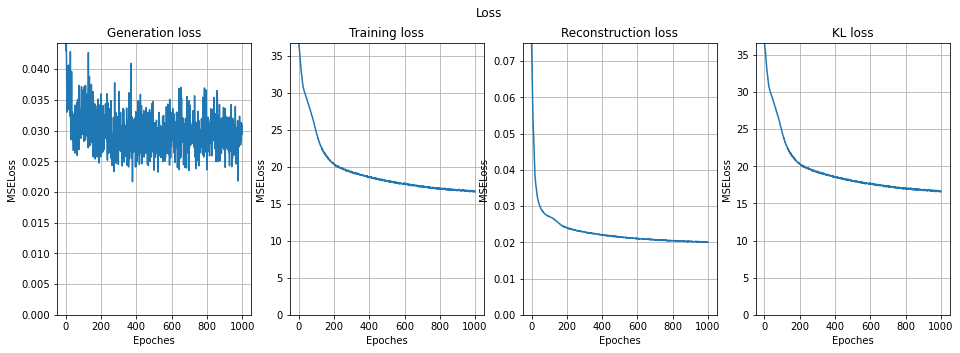

In [33]:
plot_loss(loss_set_gen, loss_set_train, loss_set_recons, loss_set_KL, 'Loss')

In [34]:
out_gen = model.decoder2(model.decoder1(data_X_val))
gen = out_gen.cpu().detach().numpy().copy()
labels = OD_val.cpu().detach().numpy().copy()
gen[labels==0] = 0

m = 0.

print('The mae loss is %.4f'%atu.mae_loss_func(gen, labels, m))
print('The mape loss is %.4f'%atu.mape_loss_func(gen, labels, m))
print('The smape loss is %.4f'%atu.smape_loss_func(gen, labels, m))
print('The nrmse loss is %.4f'%atu.nrmse_loss_func(gen, labels, m))
print('The nmae loss is %.4f'%atu.nmae_loss_func(gen, labels, m))
print('CPC is %.5f'%atu.get_CPC(gen.T, labels.T))


The mae loss is 0.1301
The mape loss is 8.5402
The smape loss is 0.5921
The nrmse loss is 0.2926
The nmae loss is 0.2218
CPC is 0.70809


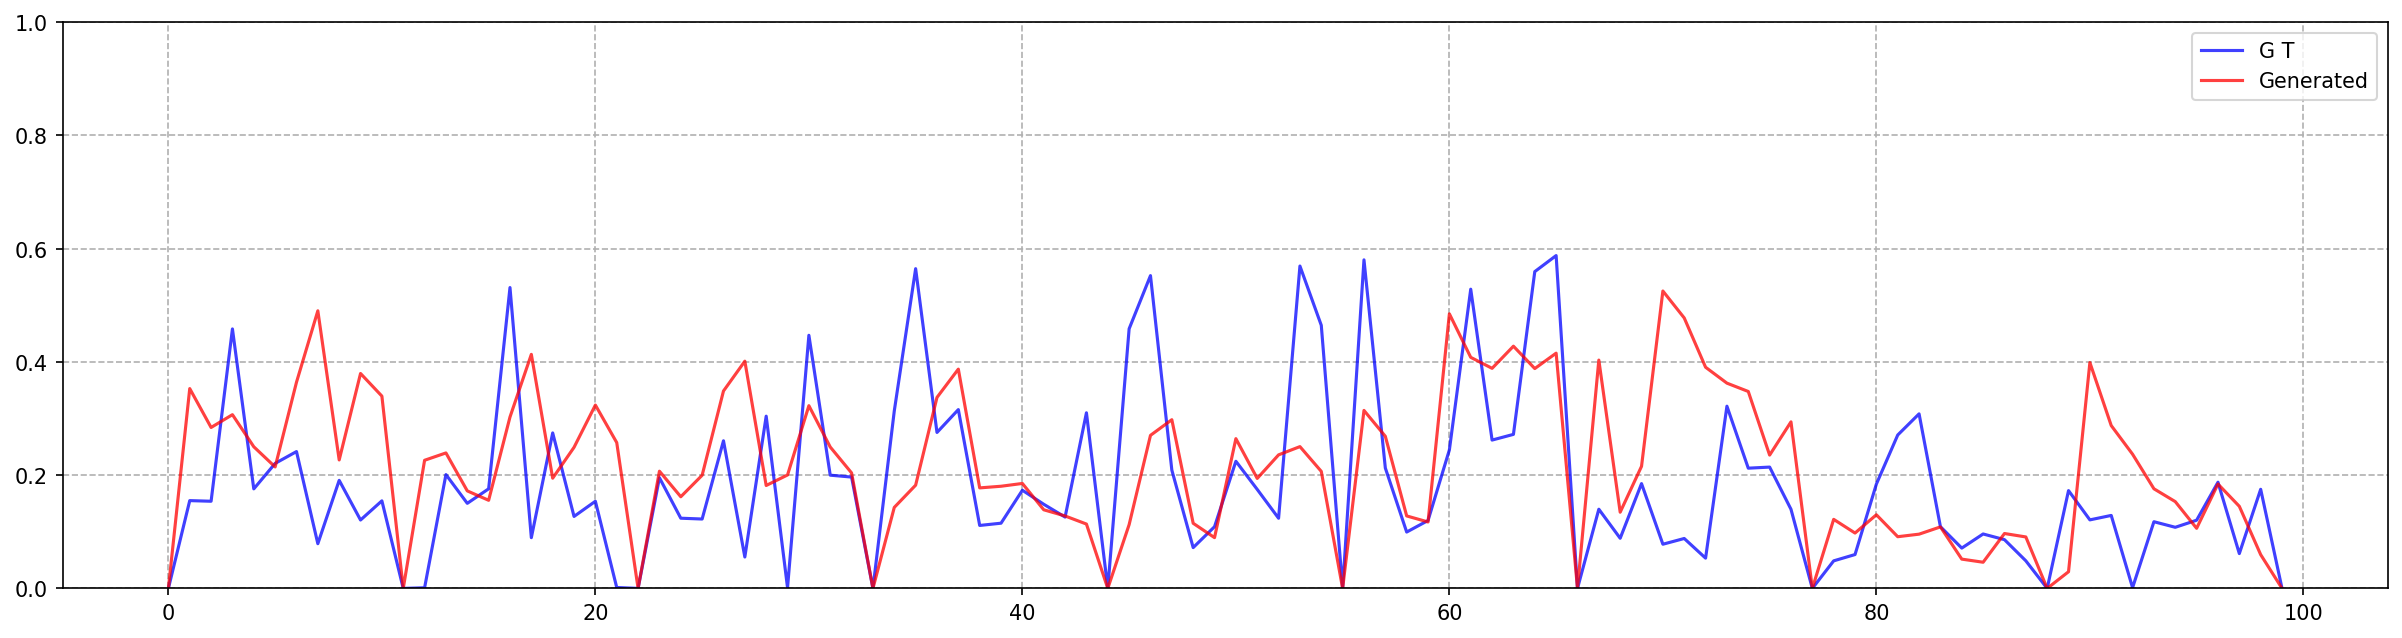

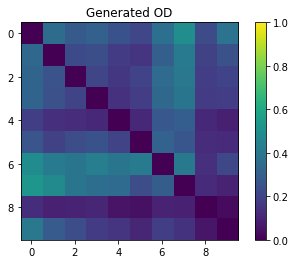

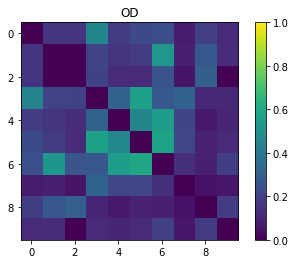

In [47]:
plt.figure(figsize=[20,5], dpi=150)
plt.plot(range(labels.shape[1]), labels.flatten(), 'b', label='G T', alpha=0.75)
plt.plot(range(gen.shape[1]), gen.flatten(), 'r', label='Generated', alpha=0.75)
plt.ylim([0,1])
plt.legend()
plt.grid(ls='--')

plt.figure()
plt.imshow(gen.reshape(10,10), vmax=1)
plt.title('Generated OD')
plt.colorbar()
plt.figure()
plt.imshow(labels.reshape(10,10), vmax=1)
plt.title('OD')
plt.colorbar()


In [48]:
# np.save('./res/vae_labels.npy', labels)
# np.save('./res/vae_pred.npy', gen)

In [50]:
# np.save('./res/vae_input.npy', np.array(data_X_val.cpu().detach().numpy()))

# Visualization of OD

In [36]:
import geopandas as gpd

In [37]:
city_coor = CSA_df.iloc[:, :3]
city_coor.head(2)

,Airport,lat,lon
0,ATL,33.640833,-84.427222
1,BOS,42.363611,-71.006111


In [38]:
us_CSA_gpd = gpd.read_file('./data/us_CSA.shp')
us_CSA_gpd.crs = {'init' :'epsg:4326'}
# us_CSA_gpd.to_crs(28992)
us_state_gpd = gpd.read_file('./data/us_state.shp')
us_state_gpd.crs = {'init' :'epsg:4326'}
# us_state_gpd.to_crs(28992)

data_X_all = us_CSA_gpd.loc[us_CSA_gpd['if_plot']==1]
data_X_all.head(2)

C:\Users\10169\anaconda3\envs\bda_traff\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\10169\anaconda3\envs\bda_traff\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
6,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.16585 32.80850, -85.16563 32.808..."
13,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,1051349,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.88392 41.32650, -71.88213 ..."


In [39]:
def plot_OD(OD, labels, title):
    # OD is 1-dimensional data
    try:
        OD = np.array(OD)
    except Exception as e:
        OD = OD.cpu().detach().numpy()
    OD = OD.reshape(10, 10)
    labels = labels.reshape(10, 10)
    OD[labels==0]=0

    fig = plt.figure(figsize=[15, 10], dpi=75)
    ax0 = fig.add_subplot(111)
    ax0.set_title(title)
    ax0.grid(ls='--')

    us_state_gpd.plot(ax=ax0, alpha=0.5, color='blue')
    data_X_all.plot(column='TotPop', ax=ax0, cmap='RdPu')

    low_lon_dest = []
    low_lat_dest = []
    mid_lon_dest = []
    mid_lat_dest = []
    high_lon_dest = []
    high_lat_dest = []
    low_lon_origin = []
    low_lat_origin = []
    mid_lon_origin = []
    mid_lat_origin = []
    high_lon_origin = []
    high_lat_origin = []


    for i in range(OD.shape[0]):
        for j in range(OD.shape[1]):
            trip_OD = OD[i, j]
            trip_label = labels[i, j]

            org = OD_df.index[i+14]
            lon_origin = CSA_df.loc[CSA_df['Airport']==org, 'lon']
            lat_origin = CSA_df.loc[CSA_df['Airport']==org, 'lat']

            dest = OD_df.columns[j+14]
            lon_dest = CSA_df.loc[CSA_df['Airport']==dest, 'lon']
            lat_dest = CSA_df.loc[CSA_df['Airport']==dest, 'lat']

            if trip_OD-labels.min()<(labels.max()-labels.min())*0.3:
                low_lon_dest.append(lon_dest)
                low_lat_dest.append(lat_dest)
                low_lon_origin.append(lon_origin)
                low_lat_origin.append(lat_origin)
            elif trip_OD-labels.min()>=(labels.max()-labels.min())*0.3 and trip_OD-labels.min()<(labels.max()-labels.min())*0.6:
                mid_lon_dest.append(lon_dest)
                mid_lat_dest.append(lat_dest)
                mid_lon_origin.append(lon_origin)
                mid_lat_origin.append(lat_origin)
            elif trip_OD-labels.min()>=(labels.max()-labels.min())*0.6:
                high_lon_dest.append(lon_dest)
                high_lat_dest.append(lat_dest)
                high_lon_origin.append(lon_origin)
                high_lat_origin.append(lat_origin)


    for i in range(len(low_lon_dest)):
        ax0.plot([low_lon_origin[i], low_lon_dest[i]], [low_lat_origin[i], low_lat_dest[i]], 'b', lw=0.3)

    for i in range(len(mid_lon_dest)):
        ax0.plot([mid_lon_origin[i], mid_lon_dest[i]], [mid_lat_origin[i], mid_lat_dest[i]], 'orange', lw=1)

    for i in range(len(high_lon_dest)):
        ax0.plot([high_lon_origin[i], high_lon_dest[i]], [high_lat_origin[i], high_lat_dest[i]], 'red', lw=1.5)

    # plot airports
    for i in city_coor.index:
        lon = city_coor.loc[i, 'lon']
        lat = city_coor.loc[i, 'lat']
        ax0.plot(lon, lat, '*', color='blue', markersize=15)



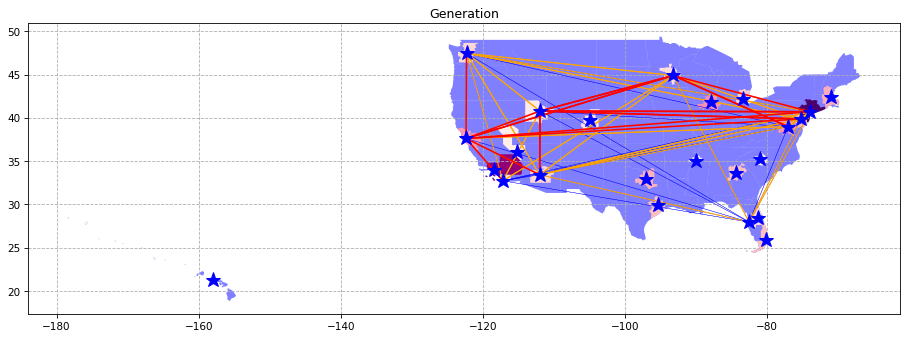

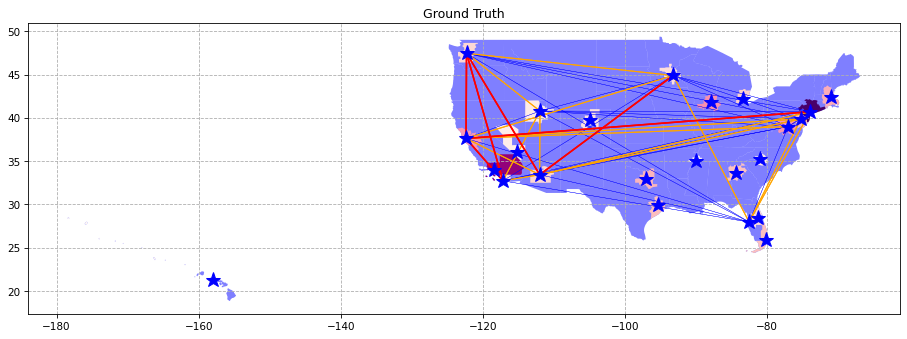

In [40]:
plot_OD(gen, labels, 'Generation')
plot_OD(labels, labels, 'Ground Truth')

In [41]:
def plot_OD2(OD, labels, title):
    # OD is 1-dimensional data
    try:
        OD = np.array(OD)
    except Exception as e:
        OD = OD.cpu().detach().numpy()
    OD = OD.reshape(10, 10)
    labels = labels.reshape(10, 10)
    OD[labels==0]=0

    fig = plt.figure(figsize=[15, 10])
    ax0 = fig.add_subplot(111)
    ax0.set_title(title)
    ax0.grid(ls='--')

    us_state_gpd.plot(ax=ax0, alpha=0.9, color='black')
    data_X_all.plot(column='TotPop', ax=ax0, cmap='RdPu')
    
    for i in range(OD.shape[0]):
        for j in range(OD.shape[1]):
            trip_OD = OD[i, j]

            org = OD_df.index[i+14]
            lon_origin = CSA_df.loc[CSA_df['Airport']==org, 'lon']
            lat_origin = CSA_df.loc[CSA_df['Airport']==org, 'lat']

            dest = OD_df.columns[j+14]
            lon_dest = CSA_df.loc[CSA_df['Airport']==dest, 'lon']
            lat_dest = CSA_df.loc[CSA_df['Airport']==dest, 'lat']
            
            c = min(np.sqrt(max(0, trip_OD) ), 1)
            ax0.plot([lon_origin, lon_dest], [lat_origin, lat_dest], lw=np.exp(c*2), color=str(c))
            
    # plot airports
    for i in city_coor.index:
        lon = city_coor.loc[i, 'lon']
        lat = city_coor.loc[i, 'lat']
        ax0.plot(lon, lat, '*', color='blue', markersize=15)
    return fig
    

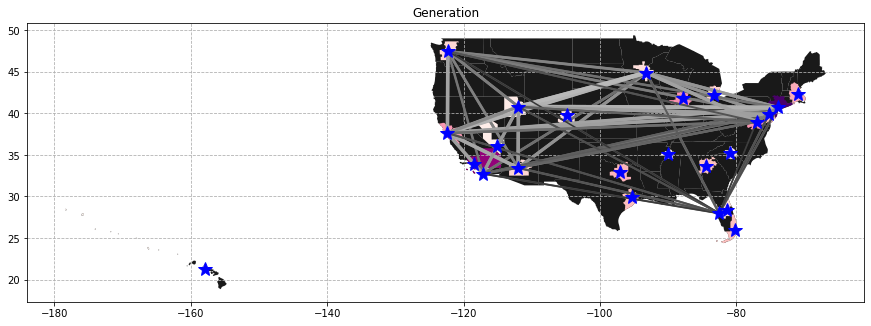

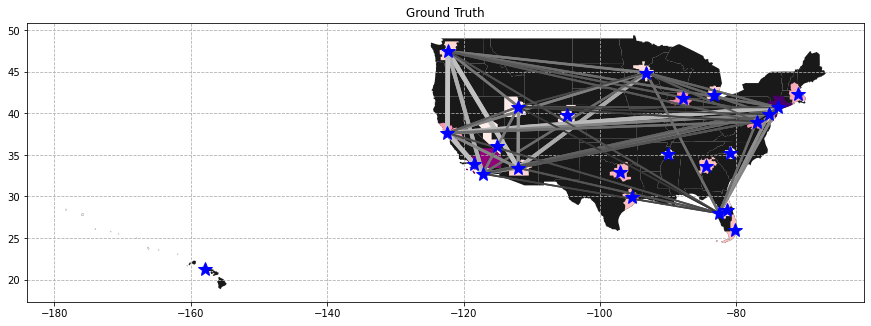

In [42]:
fig = plot_OD2(gen, labels, 'Generation')
fig = plot_OD2(labels, labels, 'Ground Truth')

# Testing Generation

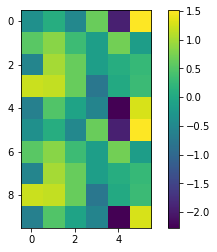

In [43]:
plt.imshow(data_X_val.cpu().reshape(-1, 6).detach().numpy())
plt.colorbar()
us_CSA_use.index = range(24)
# us_CSA_use

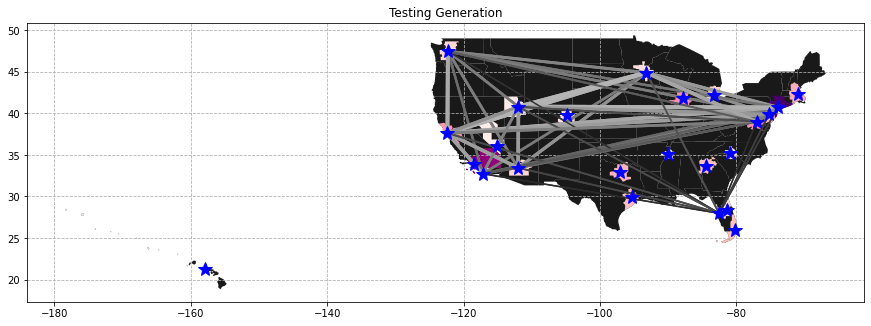

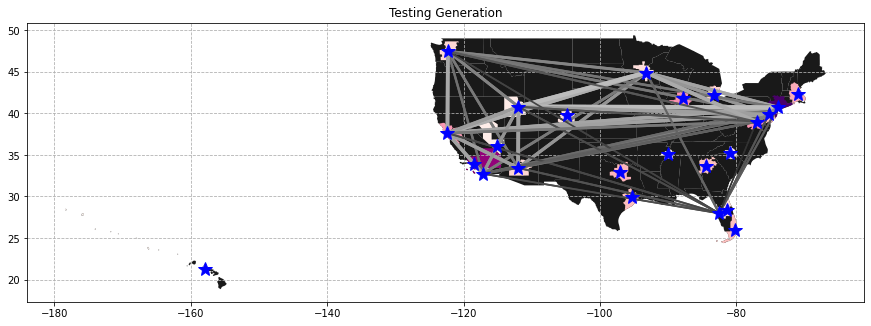

In [44]:
data_X_test = data_X_val.cpu().detach().numpy().copy()

data_X_test[0,0] = data_X_test[0,0]*1
true_mean_test = data_X_test
gen_test = model.decoder2(model.decoder1(torch.tensor(true_mean_test, dtype=torch.float32, device=device) ))
fig = plot_OD2(gen_test, labels, 'Testing Generation')
# # fig.savefig('./imgs/clip/%i.png'%i, dpi=300)
# plt.figure()
# plt.imshow(gen_test.cpu().detach().numpy().reshape(10,10), vmax=1)
# plt.title('Generated OD testing')
# plt.colorbar()
# plt.figure()
# plt.imshow(labels.reshape(10,10), vmax=1)
# plt.title('OD')
# plt.colorbar()
# plt.figure(figsize=[20,6], dpi=150)
# plt.plot(range(labels.shape[1]), labels.flatten(), label='G T', alpha=0.75)
# plt.plot(range(gen_test.cpu().detach().numpy().shape[1]), gen_test.cpu().detach().numpy().flatten(), label='generated', alpha=0.75)
# plt.legend()




data_X_test[0,0] = data_X_test[0,0]*10
true_mean_test = data_X_test
gen_test = model.decoder2(model.decoder1(torch.tensor(true_mean_test, dtype=torch.float32, device=device)))
fig = plot_OD2(gen_test, labels, 'Testing Generation')
# # fig.savefig('./imgs/clip/%i.png'%i, dpi=300)
# plt.figure()
# plt.imshow(gen_test.cpu().detach().numpy().reshape(10,10), vmax=1)
# plt.title('Generated OD testing')
# plt.colorbar()
# plt.figure()
# plt.imshow(labels.reshape(10,10))
# plt.title('OD')
# plt.colorbar()
# plt.figure(figsize=[20,6], dpi=150)
# plt.plot(range(labels.shape[1]), labels.flatten(), label='G T', alpha=0.75)
# plt.plot(range(gen_test.cpu().detach().numpy().shape[1]), gen_test.cpu().detach().numpy().flatten(), label='generated', alpha=0.75)
# plt.legend()





In [45]:
OD_df.index[14]

'MSP'